In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys

sys.path.append("../")

# Training generative model on moons dataset

> The objective of this notebook is to train a generative model on the [moons dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). The model used is a Variational Autoencoder (VAE) with a simple architecture, trained without and with conditioning on moon identity. The code is written in PyTorch, extended with Lightning and Hydra for training and configuration management.

> This repository was based on [Lightning Hydra Template](https://github.com/ashleve/lightning-hydra-template).


## Introduction

This notebook presents an exploration of training generative models on the moons dataset, with a particular focus on leveraging the Variational Autoencoder (VAE) framework. The moons dataset, despite its simplicity, offers a two-dimensional, non-linear pattern that poses a challenge for generative models. Variational Autoencoders are a class of generative models that learn a probabilistic mapping from a latent space to the data space, allowing for both efficient data compression and generation. VAEs differ from traditional autoencoders by introducing a probabilistic interpretation of the latent variables, which enables them to generate new, unseen samples by sampling from the learned latent distribution.

The aim of this report is to train a VAE on the moons dataset and analyze its generative performance, by reviewing the quality of the generated samples and the learned latent space. Additionally, it explores the impact of conditioning the VAE on the moon identity on the generative performance.


## Variational Autoencoders (VAEs)

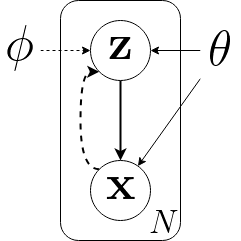

Variational Autoencoders (VAEs) are a class of generative models belonging to the family of **Latent Variable Models**. These models are based on an assumption that the data $\mathcal{X}$ is *generated* from a continuous latent variable $\mathcal{Z}$, which is not directly observed, via a probabilistic process. This involves specifying a joint distribution over the observed and latent variables $P(\mathbf{x},\mathbf{z})$

$$P(\mathbf{x},\mathbf{z})=P(\mathbf{x} | \mathbf{z})P(\mathbf{z})$$

where $P(\mathbf{z})$ is the prior distribution over the latent variables and $P(\mathbf{x} | \mathbf{z})$ is the likelihood of the data given the latent variables. Here, we assume that both distributions are parameterized by $\theta$ and their probability density functions are continuous. In VAEs, the dependency of the data $\mathbf{x}$ on the latent variables $\mathbf{z}$ is modeled by a neural network with parameters $\theta$, which is referred to as **the decoder** $P_\theta(\mathbf{x} | \mathbf{z})$.

In this setup, $P(\mathbf{x})$ can be obtained by marginalizing out the latent variables:

$$P(\mathbf{x})=\int P_\theta(\mathbf{x} | \mathbf{z})P(\mathbf{z})d\mathbf{z}$$

The objective of training latent variable model is to find the parameters $\theta$ that **maximize the likelihood of the observed data**. However, computing the likelihood $P(\mathbf{x})$ is intractable in most cases, as it involves marginalizing over the latent variables. To address this issue, VAEs introduce an **approximate inference model** $Q_\phi(\mathbf{z} | \mathbf{x})$ that approximates the true posterior $P(\mathbf{z} | \mathbf{x})$. This model, often referred to as **the encoder**, is parameterized by $\phi$ and is used to infer the latent variables given the observed data.

In this setup, the objective can be formulated as below:

$$
\begin{align*}
    \log p_\theta\left(\mathbf{x}\right) & = \mathbb{E}_{\mathbf{z} \sim q_\phi\left(\mathbf{z} | \mathbf{x}\right)} \left[\log p_\theta\left(\mathbf{x}\right)\right] & \text{$p_\theta\left(\mathbf{x}\right)$ is independent of $\mathbf{z}$}\\
    & = \mathbb{E}_{\mathbf{z}}\left[\log\frac{p_\theta\left(\mathbf{x} | \mathbf{z}\right)p\left(\mathbf{z}\right)}{p\left(\mathbf{z} | \mathbf{x}\right)}\right] & \text{Bayes Theorem}\\
    & = \mathbb{E}_{\mathbf{z}}\left[\log\frac{p_\theta\left(\mathbf{x} | \mathbf{z}\right)p\left(\mathbf{z}\right)}{p\left(\mathbf{z} | \mathbf{x}\right)}\frac{q_\phi\left(\mathbf{z} | \mathbf{x}\right)}{q_\phi\left(\mathbf{z} | \mathbf{x}\right)}\right] & \text{multiply by 1}\\
    & = \mathbb{E}_{\mathbf{z}}\left[\log p_\theta\left(\mathbf{x} | \mathbf{z}\right)\right] - \mathbb{E}_{\mathbf{z}}\left[\log \frac{q_\phi\left(\mathbf{z} | \mathbf{x}\right)}{p\left(\mathbf{z}\right)}\right] + \mathbb{E}_{\mathbf{z}}\left[\log \frac{q_\phi\left(\mathbf{z} | \mathbf{x}\right)}{p\left(\mathbf{z} | \mathbf{x}\right)}\right] & \text{logarithm}\\
    & = \underbrace{\mathbb{E}_{\mathbf{z}}\left[\log p_\theta\left(\mathbf{x} | \mathbf{z}\right)\right] - D_{KL}\left(q_\phi\left(\mathbf{z} | \mathbf{x}\right)\| p\left(\mathbf{z}\right)\right)}_{\mathcal{L}\left(\mathbf{x}, \theta, \phi\right)} + \underbrace{D_{KL}\left(q_\phi\left(\mathbf{z} | \mathbf{x}\right)\| p\left(\mathbf{z} | \mathbf{x}\right)\right)}_{\ge 0}\\
\end{align*}
$$

Calculating the KL divergence between the true posterior and its approximation is intractable, but it is always non-negative. Therefore, the objective function $\mathcal{L}\left(\mathbf{x}, \theta, \phi\right)$ is a lower bound on the log-likelihood of the data. This lower bound is known as the **Evidence Lower Bound (ELBO)** and is maximized during training. Intuitively, the ELBO consists of two terms: **the reconstruction loss**, which measures the difference between the input data and the reconstructed data, and **the KL divergence** between the approximate posterior and the prior. Usually, the prior is chosen to be a standard normal distribution $\mathcal{N}(0, \mathbf{I})$.

### Reparametrization trick

One of the challenges in training VAEs is that backpropagation can't flow through the sampling operation in the encoder. To address this issue, the **reparametrization trick** is used, which involves sampling from a simple distribution (e.g., standard normal) ($\epsilon \sim \mathcal{N}(0,\mathbf{I})$) and transforming the samples to the desired distribution using the parameters predicted by the encoder.

$$\mathbf{z} = \mathbf{\mu}(\mathbf{x}) + \mathbf{\sigma}(\mathbf{x}) \odot \epsilon$$

The reparametrization allows gradients to flow through the encoder, enabling end-to-end training of the VAE.


## Conditional Variational Autoencoders (CVAEs)

Conditional Variational Autoencoders (CVAEs) are an extension to the standard VAE framework that allows for conditioning the generative model on additional information. In CVAEs, both the encoder and the decoder are conditioned on the auxiliary information, such as class labels, denoted as $\mathbf{y}$. The inclusion of conditioning allows more control over the generative process.

In a CVAE, the joint distribution of the observed data is expressed as:

$$P(\mathbf{x}, \mathbf{z} | \mathbf{y}) = P(\mathbf{x} | \mathbf{z}, \mathbf{y})P(\mathbf{z} | \mathbf{y})$$

Here, the prior distribution $P(\mathbf{z} | \mathbf{y})$ and the likelihood $P(\mathbf{x} | \mathbf{z}, \mathbf{y})$ are conditioned on the auxiliary information $\mathbf{y}$. The formulation of the ELBO in CVAEs is similar to the standard VAE, but the encoder and decoder are conditioned on the auxiliary information. In practice, the conditioning can be achieved by concatenating the auxiliary information to the input data and the latent variables.


## Dataset and preprocessing

The moons dataset is a synthetic dataset generated using the `make_moons` function from `scikit-learn`. It consists of two interleaving half circles, making it a non-linear dataset. Its key parameters are:
- `n_samples`: the total number of samples to generate
- `noise`: the standard deviation of Gaussian noise added to the data
- `random_state`: the random seed used for generating the data

During initial exploration, applying normalization didn't affect the performance of the model due to the original scale of the data. Therefore, no preprocessing is applied to the moons dataset.

In [ ]:
from plotly.subplots import make_subplots
from sklearn.datasets import make_moons

from src.utils.visualize import visualize_data

sizes = [100, 1000, 10000]
noises = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

fig = make_subplots(
    rows=len(sizes),
    cols=len(noises),
    subplot_titles=[f"Size: {size}, Noise: {noise}" for size in sizes for noise in noises],
)


for n_idx, noise in enumerate(noises, start=1):
    for s_idx, size in enumerate(sizes, start=1):
        X, y = make_moons(n_samples=size, noise=noise)

        scatter = visualize_data(X, y, title=f"Size: {size}, Noise: {noise}")
        for trace in range(len(scatter["data"])):
            fig.append_trace(scatter["data"][trace], row=s_idx, col=n_idx)

fig.update_layout(
    height=250 * len(sizes),
    width=250 * len(noises),
    title="Moons dataset params",
    showlegend=False,
)
fig.show()

### Implementation details

The Moons dataset is created within a Lightning `DataModule` class, which is responsible for loading and preprocessing the data. The `MoonsDataModule` class is defined as below. The dataset is split into training, validation and test dataset, with a 60:20:20 ratio. Therefore, the initial dataset size is set to 2000 samples.


In [ ]:
from IPython.display import Code

Code(filename="../src/data/moons_datamodule.py", language="python")

## Model architecture

### VAE

The VAE model is implemented using PyTorch and Lightning. The model architecture consists of an encoder and a decoder, both implemented as simple 1-hidden layer feedforward neural networks. The encoder maps the input data to the latent space, while the decoder reconstructs the input data from the latent space. The latent space is parameterized by the mean and log-variance of the Gaussian distribution.

$$\mu, \rho = \text{encoder}(\mathbf{x}); \mathbf{z} \sim \mathcal{N}(\mu, e^{\rho}); \mathbf{x}_{\text{recon}} = \text{decoder}(\mathbf{z})$$

The neural networks use ReLU activation functions except for the output layers of both the encoder and decoder, which use linear activation functions to ensure the output is unconstrained. The implementation leverages the reparametrization trick to enable end-to-end training of the VAE, with a tuned epsilon value to control the sampling noise.

The model is trained using the ELBO loss, which consists of the reconstruction loss and the KL divergence between the approximate posterior and the prior.

> The ELBO loss implementation used in this project features an additional scaling factor ($\beta$), which could be used to control the importance of the KL divergence term in the loss. The $\beta$ parameter affects the trade-off between the reconstruction loss and the KL divergence, which can enforce a more disentangled latent space.

The model is implemented as a standard torch module, with the encoder and decoder defined as separate modules.


In [ ]:
Code(filename="../src/models/components/vae.py", language="python")

### CVAE

The Conditional Variational Autoencoder (CVAE) extends the VAE model to include conditioning on the moon identity. The moon identity is a binary variable that indicates the origin of the data point (moon 0 or moon 1). The CVAE model architecture is similar to the VAE, but the encoder and decoder are conditioned on the moon identity. The moon identity is concatenated to the input data and the latent variables.

$$\mu, \rho = \text{encoder}(\mathbf{x}, \mathbf{y}); \mathbf{z} \sim \mathcal{N}(\mu, e^{\rho}); \mathbf{x}_{\text{recon}} = \text{decoder}(\mathbf{z}, \mathbf{y})$$

The loss function used for the CVAE is formulated similarly to the VAE.

The CVAE model is implemented as a torch module, inheriting from the VAE model and re-using the encoder and decoder modules. The model is defined as below.


In [ ]:
Code(filename="../src/models/components/cvae.py", language="python")

## Training

The training of the VAE and CVAE models is done in an unsupervised setup, where the models are trained to reconstruct the input data and learn a meaningful latent representation. Both the encoder and the decoder are trained jointly, using the ELBO loss as the objective function. Therefore, the training process could be easily implemented in plain PyTorch as below:


In [ ]:
import torch
from tqdm.auto import trange

from src.data.moons_datamodule import MoonsDataModule
from src.models.components.vae import VAE, Decoder, Encoder, VAELoss

MAX_EPOCHS = 100

datamodule = MoonsDataModule(data_dir="../", batch_size=64)
datamodule.prepare_data()
datamodule.setup()

encoder = Encoder(input_dim=2, hidden_dims=32, latent_dim=32)
decoder = Decoder(input_dim=32, hidden_dims=32, output_dim=2)
model = VAE(encoder, decoder, eps_w=0.1)

loss_fn = VAELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in trange(MAX_EPOCHS):
    model.train()

    for x, y in datamodule.train_dataloader():
        optimizer.zero_grad()

        x_hat = model(x, y=None)
        loss, _ = loss_fn(x_hat, x)
        loss.backward()

        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for x, y in datamodule.val_dataloader():
            x_hat = model(x, y=None)
            loss, _ = loss_fn(x_hat, x)
            val_loss += loss
        val_loss /= len(datamodule.val_dataloader())
        print(f"Epoch: {epoch}, Val loss: {val_loss.item()}")

However, to allow for easier experimentation, training process logging and evaluation, the training is done using the PyTorch Lightning framework. `GenerativeLitModule` is a Lightning module that encapsulates the training and evaluation logic for both the VAE and CVAE models. The module is responsible for setting up, training and evalutaion of the model. It also handles learning rate scheduling (reducing the learning rate on a plateau).


In [ ]:
Code(filename="../src/models/generative_module.py", language="python")

### Implementation details

The training process is managed using Hydra, allowing for organized configuration management and easy experimentation with different hyperparameters. The configuration file `train.yaml` contains the master configuration for the training process, including the data parameters, model hyperparameters, training settings, and logging options.

The model training was conducted on a CPU, using the Adam optimizer. Each model was trained for maximum 1000 epochs, with early stopping based on the validation loss. The training process was monitored in Weights & Biases [generative_moons](https://wandb.ai/piotlinski/generative_moons) project.

In [ ]:
Code(filename="../configs/train.yaml", language="yaml")


Using Hydra enables quick hyperparameter tuning using Optuna. In this report, the following list of hyperparameters values was searched:
- `model.optimizer.lr`: the learning rate of the optimizer
- `data.batch_size`: the batch size used during training
- `model.model.encoder.hidden_dims`: the size of the hidden layer in the encoder
- `model.model.decoder.hidden_dims`: the size of the hidden layer in the decoder
- `model.model.encoder.latent_dim`: the size of the latent space

The objective of the optimization was to minimize the mean squared error on the validation dataset. The optimization uses the TPE sampler, with 100 trials.


## Evaluation

The evaluation of the generative models is done by analyzing the quality of the generated samples and the learned latent space. In this project, the evaluation is done by:
- Reviewing the value of the reconstruction loss (mean squared error)
- Analyzing the KL divergence term
- Visualizing the generated samples and comparing them to the original data
- Visualizing the learned latent space and the distribution of the latent variables (using UMAP)
- Exploring the influence of modifying the latent variables on the generated samples

## Results and discussion



## Conclusion
